### Sentence to Vector
Currently we have the data preprocessed as follows:


|  Valid  |  Prefix  | Next Hop  | Path  | Protocol  | Anomaly  |
|---|---|---|---|---|
| binary  |string   |  string | string  | binary(string)  | binary



### Needed soon
Need to form sentences first in pure form : prefix, next hop, path.
Create a seperate table/data frame in this format:


|  Valid  |  sentence  | Anomaly  |
|---|---|---|---|---|
| binary  |  string    | binary   |



In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from tempfile import gettempdir
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# Step 1: Download the data.
os.chdir(r'M:\Course stuff\ASPRI\data\PCH\paths')

c:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
os.listdir()

['11012018.txt',
 '11012018.txt_f.txt',
 '11012018_f.txt',
 '24012018.txt',
 '24012018.txt_f.txt',
 '24012018_f.txt',
 'ReadMe',
 'route-collector.vie.pch.net-ipv4_bgp_routes.2018.01.11.txt',
 'route-collector.vie.pch.net-ipv4_bgp_routes.2018.01.24.txt',
 'table_to_paths.py']

In [3]:
import pandas as pd
import numpy as np

In [4]:
f = open('11012018.txt')
vocabulary = f.readlines()
vocabulary = [i.strip() for i in vocabulary]

In [5]:
tokens = []
for i in range(len(vocabulary)):
    splits = vocabulary[i].split(' ')
    for j in range(len(splits)):
        tokens.append(splits[j])
unique_tokens = set(tokens)
vocabulary_size = len(unique_tokens)
len(unique_tokens),len(tokens) # unique ASes, total ASes in all paths

(24616, 926786)

In [6]:
len(vocabulary),len(list(set(vocabulary))) # total paths, unique paths

(246330, 36868)

In [7]:
def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    #count = [[]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    #print(count)
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        #print(word,index)
        if index == 0:  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

In [8]:
# Filling 4 global variables:
# data - list of codes (integers from 0 to vocabulary_size-1).
#   This is the original text but words are replaced by their codes
# count - map of words(strings) to count of occurrences
# dictionary - map of words(strings) to their codes(integers)
# reverse_dictionary - maps codes(integers) to words(strings)
data, count, dictionary, reverse_dictionary = build_dataset(tokens,len(tokens))#vocabulary,vocabulary_size)
#del vocabulary  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Least common words (+UNK)',count[-5:])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK) [['UNK', 0], ('6939', 107961), ('9002', 28904), ('6830', 21032), ('7545', 14248)]
Least common words (+UNK) [('38822', 1), ('56206', 1), ('9635', 1), ('55382', 1), ('132281', 1)]
Sample data [1, 21, 1760, 6024, 1, 21, 1760, 6024, 1, 21] ['6939', '4826', '38803', '56203', '6939', '4826', '38803', '56203', '6939', '4826']


In [9]:
len(data) #same as total ASes in paths

926786

In [10]:
len(count) #unique +1 for UNK

24617

In [11]:
len(dictionary), len(reverse_dictionary) #same size, maps every AS to uniue id == len(count)

(24617, 24617)

In [12]:
data_index = 0

# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if data_index == len(data):
            #buffer[:] = data[:span]
            for word in data[:span]:
                buffer.append(word)
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [13]:
batch, labels = generate_batch(batch_size=16, num_skips=2, skip_window=2)
for i in range(16):
    print(batch[i], reverse_dictionary[batch[i]],
                '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

1760 38803 -> 1 6939
1760 38803 -> 1 6939
6024 56203 -> 1 6939
6024 56203 -> 21 4826
1 6939 -> 1760 38803
1 6939 -> 21 4826
21 4826 -> 1 6939
21 4826 -> 1760 38803
1760 38803 -> 21 4826
1760 38803 -> 1 6939
6024 56203 -> 21 4826
6024 56203 -> 21 4826
1 6939 -> 1760 38803
1 6939 -> 1760 38803
21 4826 -> 6024 56203
21 4826 -> 1 6939


In [14]:
reverse_dictionary[29]

'10026'

In [15]:
# Step 4: Build and train a skip-gram model.

batch_size = 256
embedding_size = 32  # Dimension of the embedding vector.
skip_window = 2       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.
num_sampled = 64      # Number of negative examples to sample.

In [16]:
# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [58]:
graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/gpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable(
                tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
                tf.truncated_normal([vocabulary_size, embedding_size],
                                                        stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = 0.009
    learning_rate = tf.train.natural_exp_decay(starter_learning_rate, global_step,2500, 0.56, staircase=False)
    # Passing global_step to minimize() will increment it at each step.
    #learning_step = (tf.train.GradientDescentOptimizer(learning_rate).minimize(...my loss..., global_step=global_step))
    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    # Explanation of the meaning of NCE loss:
    #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
    loss = tf.reduce_mean(
            tf.nn.nce_loss(weights=nce_weights,
                                         biases=nce_biases,
                                         labels=train_labels,
                                         inputs=embed,
                                         num_sampled=num_sampled,
                                         num_classes=vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    #optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # What if we use AdamOptimizer
    optimizer = (tf.train.AdamOptimizer(learning_rate).minimize(loss,global_step = global_step))
    
    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings),
     1, keepdims=True)) #keep_dims is deprecated use keepdims instead
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
            normalized_embeddings, valid_dataset)
    similarity = tf.matmul(
            valid_embeddings, normalized_embeddings, transpose_b=True)
    lr_print = tf.Print(learning_rate,[learning_rate])
    # Add variable initializer.
    init = tf.global_variables_initializer()

In [59]:
# Step 5: Begin training.
num_steps = 20001

In [60]:

import time
start = time.time()
with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print('Initialized')

    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(
                batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val,__ = session.run([optimizer, loss,lr_print], feed_dict=feed_dict)
        average_loss += loss_val
        if step % 250 == 0:
            if step > 0:
                average_loss /= 250
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step ', step, ': ', average_loss,'learning rate: ',__)
            average_loss = 0
    final_embeddings = normalized_embeddings.eval()
end = time.time()
print("Time Taken: {}".format(end-start))

Initialized
Average loss at step  0 :  252.064697265625 learning rate:  0.009
Average loss at step  250 :  228.3384051513672 learning rate:  0.008509852
Average loss at step  500 :  169.77141720581054 learning rate:  0.008046398
Average loss at step  750 :  159.86314419555663 learning rate:  0.0076081837
Average loss at step  1000 :  125.26792109680176 learning rate:  0.007193836
Average loss at step  1250 :  118.27906364440918 learning rate:  0.006802053
Average loss at step  1500 :  97.93184477233886 learning rate:  0.0064316075
Average loss at step  1750 :  106.1583726348877 learning rate:  0.0060813366
Average loss at step  2000 :  98.81370176696777 learning rate:  0.005750142
Average loss at step  2250 :  78.91350198364258 learning rate:  0.005436984
Average loss at step  2500 :  66.02452368164063 learning rate:  0.0051408815
Average loss at step  2750 :  79.82804012298584 learning rate:  0.0048609045
Average loss at step  3000 :  78.59286647796631 learning rate:  0.0045961756
Ave

In [61]:
final_embeddings.shape

(24616, 32)

In [62]:
s2v = vocabulary.copy()
for i in range(len(vocabulary)):
    splits = vocabulary[i].split(' ')
    splits2 = splits
    t= []
    for j in range(len(splits)):
        #print(type(j))
        splits2[j]= final_embeddings[dictionary[splits[j]]-1]
    s2v[i] = splits

In [63]:
unique_tokens = list(set(tokens))

In [64]:
bigram_dict = {}
bigrams = [b for l in vocabulary for b in zip(l.split(' ')[:-1],l.split(' ')[1:])]

In [65]:
for i in range(len(bigrams)):
    a,b = bigrams[i][0],bigrams[i][1]
    bigram_dict[bigrams[i]] = np.dot(final_embeddings[dictionary[a]-1],final_embeddings[dictionary[b]-1]) 

In [66]:
def find_ngrams(strx,n):
    return list(zip(*[strx.split(' ')[i:] for i in range(n)]))
t = find_ngrams(vocabulary[0],2)

In [67]:
vocabulary[0],(t)

('6939 4826 38803 56203',
 [('6939', '4826'), ('4826', '38803'), ('38803', '56203')])

In [68]:
r_s = 0
for i in t:
    r_s += bigram_dict[i]

In [69]:
r_s

0.3489672839641571

In [70]:
def sbs(arr): #sum of bigrams in each sentence
    sbs = []
    for i in range(len(arr)):
        t = list(find_ngrams(vocabulary[i],2))
        t = [bigram_dict[i] for i in t]
        sbs.append(sum(t))
    return sbs
array_of_bigram_sums = sbs(vocabulary)

In [71]:
total_sum = sum(array_of_bigram_sums)

In [72]:
total_sum

433846.876114944

In [73]:
avg = total_sum/len(vocabulary)
avg

1.7612425450206795

In [74]:
min(array_of_bigram_sums),max(array_of_bigram_sums)

(-0.5612563937902451, 27.71648621559143)

In [75]:
np.std(array_of_bigram_sums)

2.1347853364292146

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


(array([1.8532e+05, 4.3210e+04, 1.1427e+04, 4.1580e+03, 1.7970e+03,
        1.5600e+02, 1.7600e+02, 7.3000e+01, 6.0000e+00, 7.0000e+00]),
 array([-0.56125639,  2.26651787,  5.09429213,  7.92206639, 10.74984065,
        13.57761491, 16.40538917, 19.23316343, 22.06093769, 24.88871195,
        27.71648622]),
 <a list of 10 Patch objects>)

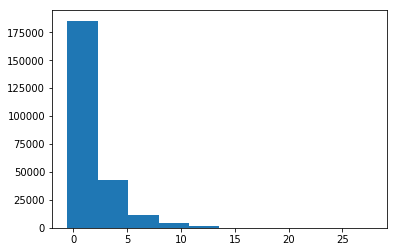

In [77]:
plt.hist(array_of_bigram_sums)

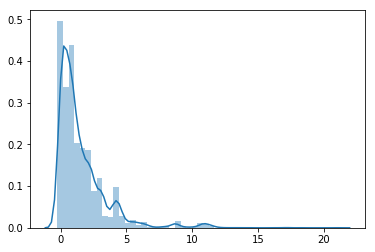

In [78]:
sns.distplot(array_of_bigram_sums[:10000])

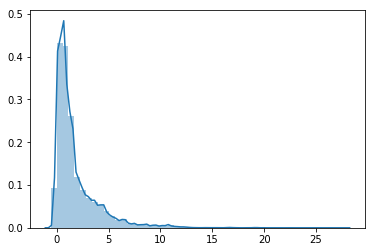

In [79]:
sns.distplot(array_of_bigram_sums)

In [80]:
from scipy import stats
stats.mode(array_of_bigram_sums)

ModeResult(mode=array([0.]), count=array([9272]))

In [82]:
random_path = "6939 4826 4770 4770 4770 4770 4770 4770 24074 4651"
rpb = find_ngrams(random_path,2)
arr = sbs(rpb)

In [84]:
sum(arr)

4.588510937988758

In [85]:
rpb

[('6939', '4826'),
 ('4826', '4770'),
 ('4770', '4770'),
 ('4770', '4770'),
 ('4770', '4770'),
 ('4770', '4770'),
 ('4770', '4770'),
 ('4770', '24074'),
 ('24074', '4651')]

In [87]:
bigram_dict[('4770','4770')]

0.99999994

In [93]:
bigram_dict[('6939','4826')]

0.21759763

In [95]:
np.dot(final_embeddings[dictionary['6939']],final_embeddings[dictionary['24074']])

0.0712905

In [100]:
np.dot(final_embeddings[dictionary['4770']],final_embeddings[dictionary['6939']])

0.422816